In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Flatten
from sklearn.decomposition import PCA

In [2]:
# Load the dictionary from the JSON file for images with Background
json_file = 'data&labels.json'
with open(json_file, 'r') as f:
    image_dict = json.load(f)

# Load images and labels from the dictionary
image_paths, labels = zip(*image_dict.items())

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
# Load images and resize them to a fixed size
images = []
for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, (100, 100))  # Resize to 100x100 (adjust as needed)
    images.append(img)

images = np.array(images)

In [3]:
# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Extract features using the VGG16 model
features = vgg_model.predict(preprocess_input(images.copy()))
features = features.reshape(features.shape[0], -1)

2024-05-01 20:19:21.694000: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 17s 510ms/step


In [4]:
# Perform PCA and select the top k features
n_components = 512  # Number of principal components to retain initially
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features)

# Get the explained variance ratio for each principal component
explained_variance_ratios = pca.explained_variance_ratio_

# Select the top k features based on the explained variance ratios
k = 256  # Number of top features to select
top_features_indices = np.argsort(explained_variance_ratios)[::-1][:k]
top_features = features_pca[:, top_features_indices]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(top_features, labels, test_size=0.20, random_state=42)

In [5]:
# Define the logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Train the logistic regression model
logreg.fit(X_train, y_train)

# Evaluate the model
accuracy = logreg.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8640776699029126


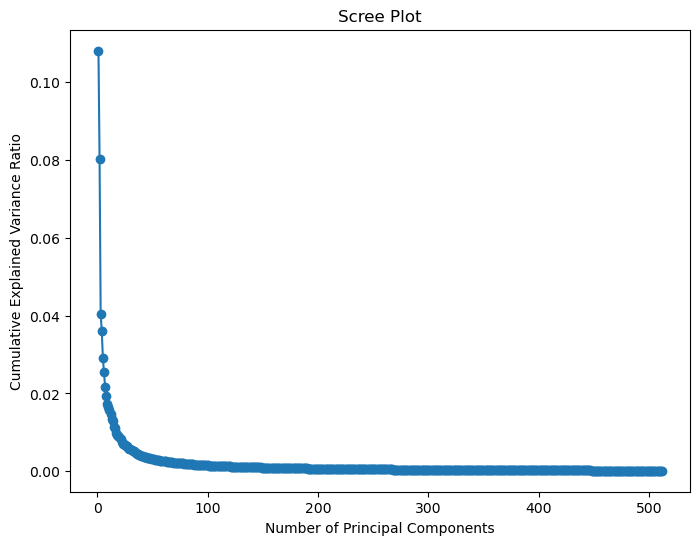

In [6]:
# Create a scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 513), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

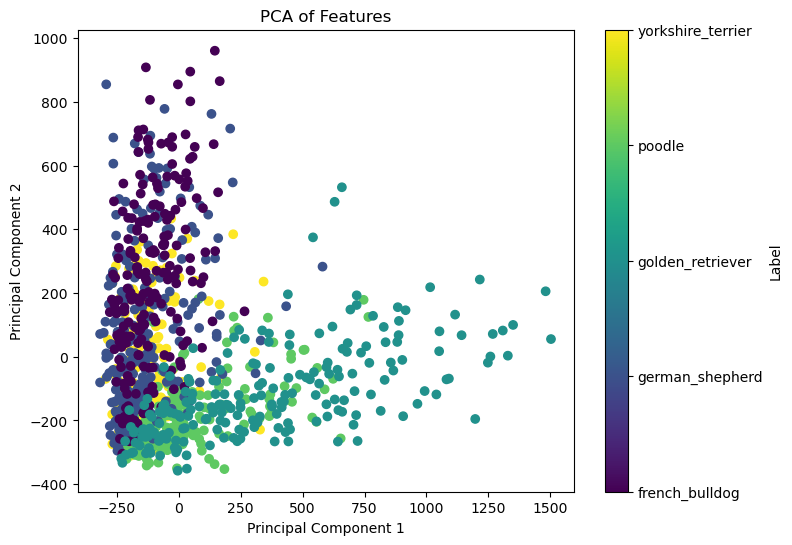

In [9]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features')
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), label='Label').set_ticklabels(label_encoder.classes_)
plt.show()